In [ ]:
pip install gwaslab 


In [1]:
import gwaslab as gl
import pandas as pd
import numpy as np
import seaborn as sns
import os
import glob
import matplotlib.pyplot as plt
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
pandas2ri.activate()

INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /usr/lib/R
INFO:rpy2.situation:R library path: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/home/icog-bioai/jdk-11.0.2/lib/server
INFO:rpy2.situation:LD_LIBRARY_PATH: /usr/lib/R/lib:/usr/lib/x86_64-linux-gnu:/home/icog-bioai/jdk-11.0.2/lib/server
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.


## Load gwas data

In [2]:
import pandas as pd
import gzip

file_path = "../../data/susie/gwas/21001_raw.gwas.imputed_v3.both_sexes.tsv.bgz"
with gzip.open(file_path, 'rt') as f:
    gwas_data_df = pd.read_csv(f, sep='\t') 


In [3]:
gwas_data_df.head()

,variant,minor_allele,minor_AF,low_confidence_variant,n_complete_samples,AC,ytx,beta,se,tstat,pval
0,1:15791:C:T,T,5.446880e-09,True,359983,0.003922,1.238950e-01,894.616000,1204.870000,0.742499,0.457786
1,1:69487:G:A,A,5.768250e-06,True,359983,4.152940,1.035150e+02,-2.715450,2.360060,-1.150590,0.249902
2,1:69569:T:C,C,1.878960e-04,True,359983,135.278000,3.644560e+03,-0.484284,0.423462,-1.143630,0.252778
3,1:139853:C:T,T,5.681100e-06,True,359983,4.090200,1.018400e+02,-2.703560,2.360130,-1.145510,0.251997
4,1:692794:CA:C,C,1.105900e-01,False,359983,79621.100000,2.179000e+06,-0.016436,0.019585,-0.839228,0.401342


## Data Processing 

In [4]:
split_variant = gwas_data_df['variant'].str.split(':', expand=True)
gwas_data_df['CHR'] = split_variant[0]
gwas_data_df['POS'] = split_variant[1]
gwas_data_df['A2'] = split_variant[2]
gwas_data_df['A1'] = split_variant[3]

In [5]:
gwas_data_df.head()

,variant,minor_allele,minor_AF,low_confidence_variant,n_complete_samples,AC,ytx,beta,se,tstat,pval,CHR,POS,A2,A1
0,1:15791:C:T,T,5.446880e-09,True,359983,0.003922,1.238950e-01,894.616000,1204.870000,0.742499,0.457786,1,15791,C,T
1,1:69487:G:A,A,5.768250e-06,True,359983,4.152940,1.035150e+02,-2.715450,2.360060,-1.150590,0.249902,1,69487,G,A
2,1:69569:T:C,C,1.878960e-04,True,359983,135.278000,3.644560e+03,-0.484284,0.423462,-1.143630,0.252778,1,69569,T,C
3,1:139853:C:T,T,5.681100e-06,True,359983,4.090200,1.018400e+02,-2.703560,2.360130,-1.145510,0.251997,1,139853,C,T
4,1:692794:CA:C,C,1.105900e-01,False,359983,79621.100000,2.179000e+06,-0.016436,0.019585,-0.839228,0.401342,1,692794,CA,C


In [6]:
gwas_data_df.to_csv("../../data/susie/gwas/21001_raw.gwas.imputed_v3.both_sexes.tsv", index=False)

## Minor Allele Frequency and Significant SNP Filtering 

In [7]:
gwas_data_df=gwas_data_df.rename(columns={'variant':'SNPID', 'pval':'P'})

minor_af_filtered_df = gwas_data_df[gwas_data_df['minor_AF'] > 0.05]
significant_snp_df = minor_af_filtered_df[minor_af_filtered_df['P'] <= 5e-8]
significant_snp_df = significant_snp_df[~significant_snp_df['SNPID'].str.startswith('X:')]


In [8]:
significant_snp_df.head()

,SNPID,minor_allele,minor_AF,low_confidence_variant,n_complete_samples,AC,ytx,beta,se,tstat,P,CHR,POS,A2,A1
4306,1:1524437:T:C,C,0.389681,False,359983,280557.0,7673530.0,-0.071795,0.012639,-5.68043,1.344570e-08,1,1524437,T,C
4307,1:1524998:A:T,T,0.362078,False,359983,260683.0,7128940.0,-0.076017,0.012807,-5.93559,2.930620e-09,1,1524998,A,T
4311,1:1526062:T:C,C,0.386887,False,359983,278546.0,7617930.0,-0.074176,0.012566,-5.90308,3.570960e-09,1,1526062,T,C
4318,1:1527952:T:C,C,0.371677,False,359983,267595.0,7316850.0,-0.081444,0.012498,-6.51631,7.215260e-11,1,1527952,T,C
4325,1:1529994:G:C,C,0.373186,False,359983,268682.0,7346170.0,-0.082007,0.012277,-6.67983,2.395670e-11,1,1529994,G,C


In [20]:
significant_snp_df.to_csv("../../data/susie/processed_raw_data/significant_snps.csv", index=False)

## Data Formatting for COJO

In [10]:
formatted_cojo_df = significant_snp_df.rename(columns={
    'SNPID': 'SNP',
    'A1': 'A1',
    'A2': 'A2',
    'minor_AF': 'freq',
    'beta': 'b',
    'se': 'se',
    'P': 'p',
    'n_complete_samples': 'N'
})

cojo_ready_df = formatted_cojo_df[['SNP', 'A1', 'A2', 'freq', 'b', 'se', 'p', 'N']]
cojo_ready_df.head()
cojo_ready_df.to_csv("../../data/susie/reformated_data_for_cojo/cojo_extracted_file_37.csv", sep=" ", index=False)

## COJO Analysis

## RUN COJO

step 1. Download gcta software
`wget https://yanglab.westlake.edu.cn/software/gcta/bin/gcta-1.94.3-linux-kernel-3-x86_64.zip`

step2. unzip the downloaded folder
`gcta-1.94.3-linux-kernel-3-x86_64.zip`
`cd gcta-1.94.3-linux-kernel-3-x86_64`

step3. install gcta if not installed 
`mamba install gcta`
`export PATH=$PWD:$PATH`

step4. run cojo
`gcta64 --bfile ../ALL_chr/plink_b_files/merged_data --maf 0.05 --cojo-file ../reformated_data_for_cojo/cojo_extracted_file.csv --cojo-slct --out ../cojo/all_chr/all_chr_cojo`

`gcta64 --bfile ../../plink_binary_col/merged_data --maf 0.05 --cojo-file ../data/susie/reformated_data_for_cojo/cojo_extracted_file_col_37.csv --cojo-slct --out ../../cojo/all_chr/all_chr_cojo_col`

In [ ]:
gcta64 --bfile ../../plink_binary/merged_data --maf 0.05 --cojo-file ../../reformated_data_for_cojo/cojo_extracted_file.csv --cojo-slct --out ../../cojo/all_chr_new_merged_data/

## COJO OUTPUT

icog-bioai@dl:/mnt/hdd_2/rediet/hypothesis-generation-demo/data/susie/gcta/gcta-1.94.3-linux-kernel-3-x86_64$ gcta64 --bfile ../../ALL_chr/plink_b_files/merged_data --maf 0.05 --cojo-file ../../reformated_data_for_cojo/cojo_extr
acted_file.csv --cojo-slct --out all_chr_cojo
*******************************************************************
* Genome-wide Complex Trait Analysis (GCTA)
* version v1.94.1 Linux
* Built at Dec 16 2024 16:35:13, by GCC 8.3
* (C) 2010-present, Yang Lab, Westlake University
* Please report bugs to Jian Yang <jian.yang@westlake.edu.cn>
*******************************************************************
Analysis started at 06:33:19 PST on Fri Feb 28 2025.
Hostname: dl

Accepted options:
--bfile ../../ALL_chr/plink_b_files/merged_data
--maf 0.05
--cojo-file ../../reformated_data_for_cojo/cojo_extracted_file.csv
--cojo-slct
--out ../../cojo/all_chr/all_chr_cojo


Reading PLINK FAM file from [../../ALL_chr/plink_b_files/merged_data.fam].
2504 individuals to be included from [../../ALL_chr/plink_b_files/merged_data.fam].
Reading PLINK BIM file from [../../ALL_chr/plink_b_files/merged_data.bim].
46867 SNPs to be included from [../../ALL_chr/plink_b_files/merged_data.bim].
Reading PLINK BED file from [../../ALL_chr/plink_b_files/merged_data.bed] in SNP-major format ...
Genotype data for 2504 individuals and 46867 SNPs to be included from [../../ALL_chr/plink_b_files/merged_data.bed].
Calculating allele frequencies ...
Filtering SNPs with MAF > 0.05 ...
After filtering SNPs with MAF > 0.05, there are 45866 SNPs (1001 SNPs with MAF < 0.05).

Reading GWAS summary-level statistics from [../../reformated_data_for_cojo/cojo_extracted_file.csv] ...
GWAS summary statistics of 49937 SNPs read from [../../reformated_data_for_cojo/cojo_extracted_file.csv].
Phenotypic variance estimated from summary statistics of all 49937 SNPs: 22.4081 (variance of logit for case-control studies).
Matching the GWAS meta-analysis results to the genotype data ...
Warning: can't match the reference alleles of 5 SNPs to those in the genotype data. These SNPs have been saved in [all_chr_cojo.badsnps].
10022 SNP(s) have large difference of allele frequency between the GWAS summary data and the reference sample. These SNPs have been saved in [all_chr_cojo.freq.badsnps].
35839 SNPs are matched to the genotype data.
Calculating the variance of SNP genotypes ...

Performing stepwise model selection on 35839 SNPs to select association signals ... (p cutoff = 5e-08; collinearity cutoff = 0.9)
(Assuming complete linkage equilibrium between SNPs which are more than 10Mb away from each other)
5 associated SNPs have been selected.
10 associated SNPs have been selected.
15 associated SNPs have been selected.
20 associated SNPs have been selected.
25 associated SNPs have been selected.
30 associated SNPs have been selected.
35 associated SNPs have been selected.
40 associated SNPs have been selected.
45 associated SNPs have been selected.
50 associated SNPs have been selected.
55 associated SNPs have been selected.
60 associated SNPs have been selected.
65 associated SNPs have been selected.
70 associated SNPs have been selected.
75 associated SNPs have been selected.
80 associated SNPs have been selected.
85 associated SNPs have been selected.
90 associated SNPs have been selected.
95 associated SNPs have been selected.
100 associated SNPs have been selected.
105 associated SNPs have been selected.
110 associated SNPs have been selected.
115 associated SNPs have been selected.
120 associated SNPs have been selected.
125 associated SNPs have been selected.
130 associated SNPs have been selected.
135 associated SNPs have been selected.
140 associated SNPs have been selected.
145 associated SNPs have been selected.
150 associated SNPs have been selected.
155 associated SNPs have been selected.
160 associated SNPs have been selected.
165 associated SNPs have been selected.
170 associated SNPs have been selected.
175 associated SNPs have been selected.
180 associated SNPs have been selected.
185 associated SNPs have been selected.
190 associated SNPs have been selected.
195 associated SNPs have been selected.
200 associated SNPs have been selected.
205 associated SNPs have been selected.
210 associated SNPs have been selected.
215 associated SNPs have been selected.
220 associated SNPs have been selected.
225 associated SNPs have been selected.
230 associated SNPs have been selected.
235 associated SNPs have been selected.
240 associated SNPs have been selected.
245 associated SNPs have been selected.
250 associated SNPs have been selected.
255 associated SNPs have been selected.
260 associated SNPs have been selected.
265 associated SNPs have been selected.
270 associated SNPs have been selected.
275 associated SNPs have been selected.
280 associated SNPs have been selected.
285 associated SNPs have been selected.
290 associated SNPs have been selected.
295 associated SNPs have been selected.
300 associated SNPs have been selected.
305 associated SNPs have been selected.
310 associated SNPs have been selected.
315 associated SNPs have been selected.
320 associated SNPs have been selected.
325 associated SNPs have been selected.
330 associated SNPs have been selected.
335 associated SNPs have been selected.
340 associated SNPs have been selected.
345 associated SNPs have been selected.
350 associated SNPs have been selected.
355 associated SNPs have been selected.
360 associated SNPs have been selected.
365 associated SNPs have been selected.
370 associated SNPs have been selected.
375 associated SNPs have been selected.
380 associated SNPs have been selected.
385 associated SNPs have been selected.
390 associated SNPs have been selected.
395 associated SNPs have been selected.
400 associated SNPs have been selected.
405 associated SNPs have been selected.
410 associated SNPs have been selected.
415 associated SNPs have been selected.
420 associated SNPs have been selected.
425 associated SNPs have been selected.
430 associated SNPs have been selected.
435 associated SNPs have been selected.
440 associated SNPs have been selected.
445 associated SNPs have been selected.
450 associated SNPs have been selected.
455 associated SNPs have been selected.
460 associated SNPs have been selected.
465 associated SNPs have been selected.
470 associated SNPs have been selected.
475 associated SNPs have been selected.
480 associated SNPs have been selected.
485 associated SNPs have been selected.
490 associated SNPs have been selected.
495 associated SNPs have been selected.
500 associated SNPs have been selected.
505 associated SNPs have been selected.
Finally, 506 associated SNPs are selected.
Performing joint analysis on all the 506 selected signals ...
Saving the 506 independent signals to [all_chr_cojo.jma.cojo] ...
Saving the LD structure of 506 independent signals to [all_chr_cojo.ldr.cojo] ...
Saving the conditional analysis results of 33822 remaining SNPs to [all_chr_cojo.cma.cojo] ...
(5 SNPs eliminated by backward selection and 1506 SNPs filtered by collinearity test are not included in the output)

Analysis finished at 06:41:37 PST on Fri Feb 28 2025
Overall computational time: 8 minutes 18 sec.

## Extract Most significant variant snd Define region around the most significant SNP

In [21]:
import pandas as pd
cojo_results_df = pd.read_csv("../../data/susie/cojo/all_chr/all_chr_cojo.jma.cojo", delim_whitespace=True)
cojo_results_df.head()


/tmp/ipykernel_3000633/3092249479.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  cojo_results_df = pd.read_csv("../../data/susie/cojo/all_chr/all_chr_cojo.jma.cojo", delim_whitespace=True)


,Chr,SNP,bp,refA,freq,b,se,p,n,freq_geno,bJ,bJ_se,pJ,LD_r
0,1,1:1590521:G:A,1590521,A,0.265231,-0.100267,0.012675,2.562560e-15,357785,0.258986,-0.126050,0.012930,1.873560e-22,0.003818
1,1,1:1866376:G:A,1866376,A,0.496263,0.067971,0.011644,5.306640e-09,330513,0.516374,0.074590,0.011663,1.598820e-10,0.034421
2,1,1:2427712:C:T,2427712,T,0.455874,-0.070197,0.011267,4.660130e-10,355744,0.326478,-0.082146,0.011438,6.870130e-13,-0.099375
3,1,1:6669970:C:G,6669970,G,0.355676,0.064158,0.011662,3.767190e-08,359447,0.358027,0.075553,0.011830,1.696020e-10,0.000000
4,1,1:23353906:CT:C,23353906,C,0.167309,0.085668,0.014989,1.094920e-08,357912,0.296126,0.083185,0.014994,2.891550e-08,0.023570


In [22]:
cojo_results_df.shape

(506, 14)

In [23]:
most_significant_snp = cojo_results_df.sort_values(by='p').head(1)
most_significant_snp

,Chr,SNP,bp,refA,freq,b,se,p,n,freq_geno,bJ,bJ_se,pJ,LD_r
416,16,16:53828066:C:T,53828066,T,0.392165,0.349002,0.011405,1.224550e-205,360397,0.221446,-0.481828,0.030674,1.336110e-55,0.821113


In [24]:
import pandas as pd
significant_snp_df=pd.read_csv("../../data/susie/processed_raw_data/significant_snps.csv", delim_whitespace=False)
significant_snp_df

/tmp/ipykernel_3000633/254838130.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  significant_snp_df=pd.read_csv("../../data/susie/processed_raw_data/significant_snps.csv", delim_whitespace=False)


,SNPID,minor_allele,minor_AF,low_confidence_variant,n_complete_samples,AC,ytx,beta,se,tstat,P,CHR,POS,A2,A1
0,1:1524437:T:C,C,0.389681,False,359983,280557.0,7673530.0,-0.071795,0.012639,-5.68043,1.344570e-08,1,1524437,T,C
1,1:1524998:A:T,T,0.362078,False,359983,260683.0,7128940.0,-0.076017,0.012807,-5.93559,2.930620e-09,1,1524998,A,T
2,1:1526062:T:C,C,0.386887,False,359983,278546.0,7617930.0,-0.074176,0.012566,-5.90308,3.570960e-09,1,1526062,T,C
3,1:1527952:T:C,C,0.371677,False,359983,267595.0,7316850.0,-0.081444,0.012498,-6.51631,7.215260e-11,1,1527952,T,C
4,1:1529994:G:C,C,0.373186,False,359983,268682.0,7346170.0,-0.082007,0.012277,-6.67983,2.395670e-11,1,1529994,G,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49932,22:40718100:G:A,A,0.206546,False,359983,148706.0,4062300.0,-0.081962,0.013802,-5.93855,2.878220e-09,22,40718100,G,A
49933,22:40720704:A:G,G,0.350510,False,359983,252355.0,6895670.0,-0.085960,0.011722,-7.33344,2.247820e-13,22,40720704,A,G
49934,22:40720963:C:T,C,0.419873,False,359983,417672.0,11428300.0,-0.063540,0.011365,-5.59108,2.258230e-08,22,40720963,C,T
49935,22:40722745:A:G,G,0.350605,False,359983,252424.0,6897760.0,-0.084771,0.011740,-7.22060,5.185860e-13,22,40722745,A,G


## Expanding the region of each independet snp identified by cojo

In [17]:
window_size = 500000  
output_dir = "../data/susie/expanded_regions"  

for index, row in cojo_results_df.iterrows():
    chrom = row["Chr"]  
    pos = row["bp"]  
    start_pos = pos - window_size
    end_pos = pos + window_size

    df_region = significant_snp_df[
        (significant_snp_df["CHR"] == chrom) & 
        (significant_snp_df["POS"] >= start_pos) & 
        (significant_snp_df["POS"] <= end_pos)
    ]
    
    
    output_file = f"{output_dir}/chr{chrom}_pos{pos}_snps.txt"
    df_region.to_csv(output_file, sep="\t", index=False)

    print(f"Extracted {len(df_region)} SNPs for Chr{chrom} position {pos} and saved to {output_file}")


Extracted 70 SNPs for Chr1 position 1590521 and saved to ../data/susie/expanded_regions/chr1_pos1590521_snps.txt
Extracted 70 SNPs for Chr1 position 1866376 and saved to ../data/susie/expanded_regions/chr1_pos1866376_snps.txt
Extracted 75 SNPs for Chr1 position 2427712 and saved to ../data/susie/expanded_regions/chr1_pos2427712_snps.txt
Extracted 5 SNPs for Chr1 position 6669970 and saved to ../data/susie/expanded_regions/chr1_pos6669970_snps.txt
Extracted 106 SNPs for Chr1 position 23353906 and saved to ../data/susie/expanded_regions/chr1_pos23353906_snps.txt
Extracted 14 SNPs for Chr1 position 32165495 and saved to ../data/susie/expanded_regions/chr1_pos32165495_snps.txt
Extracted 59 SNPs for Chr1 position 33795572 and saved to ../data/susie/expanded_regions/chr1_pos33795572_snps.txt
Extracted 4 SNPs for Chr1 position 34584393 and saved to ../data/susie/expanded_regions/chr1_pos34584393_snps.txt
Extracted 114 SNPs for Chr1 position 39571992 and saved to ../data/susie/expanded_regions

Extracted 41 SNPs for Chr10 position 34091492 and saved to ../data/susie/expanded_regions/chr10_pos34091492_snps.txt
Extracted 2 SNPs for Chr10 position 53674590 and saved to ../data/susie/expanded_regions/chr10_pos53674590_snps.txt
Extracted 5 SNPs for Chr10 position 64821926 and saved to ../data/susie/expanded_regions/chr10_pos64821926_snps.txt
Extracted 200 SNPs for Chr10 position 76101122 and saved to ../data/susie/expanded_regions/chr10_pos76101122_snps.txt
Extracted 18 SNPs for Chr10 position 76853963 and saved to ../data/susie/expanded_regions/chr10_pos76853963_snps.txt
Extracted 1 SNPs for Chr10 position 78760959 and saved to ../data/susie/expanded_regions/chr10_pos78760959_snps.txt
Extracted 35 SNPs for Chr10 position 87490850 and saved to ../data/susie/expanded_regions/chr10_pos87490850_snps.txt
Extracted 13 SNPs for Chr10 position 93010383 and saved to ../data/susie/expanded_regions/chr10_pos93010383_snps.txt
Extracted 157 SNPs for Chr10 position 99778226 and saved to ../dat

## Map Independent SNPs from COJO analysis to their nearest gene

In [56]:
results=pd.read_csv("/tmp/Rtmpuvo3XH/results/GWAS/21001bothSexes/FTO/Multi-finemap/1KGphase3_LD.Multi-finemap.tsv",sep="\t")

In [57]:
results.head()

,SNP,CHR,POS,A1,A2,MINOR_ALLELE,Freq,LOW_CONFIDENCE_VARIANT,N,AC,...,SUSIE.CS,SUSIE.PP,FINEMAP.CS,FINEMAP.PP,FINEMAP.k,FINEMAP.PP_snp,Support,Consensus_SNP,mean.PP,mean.CS
0,rs10468280,16,53827479,A,G,G,0.392237,False,359983,282397.000,...,0,0.456371,0.0,0.449551,1.0,NaN,0,False,0.301974,0
1,rs111241709,16,53828504,T,C,C,0.008945,False,359983,6440.100,...,0,0.303159,NaN,NaN,NaN,NaN,0,False,0.101053,0
2,rs140241958,16,53828971,A,G,G,0.001220,False,359983,878.514,...,0,0.593300,NaN,NaN,NaN,NaN,0,False,0.197767,0
3,rs62033408,16,53827962,A,G,G,0.392247,False,359983,282405.000,...,0,0.555538,0.0,0.550449,1.0,NaN,0,False,0.368662,0
4,rs73607075,16,53828968,T,C,C,0.063017,False,359983,45369.800,...,0,0.012051,NaN,NaN,NaN,NaN,0,False,0.004017,0


In [24]:
vautils = importr("vautils")
dplyr = importr("dplyr")
readr = importr("readr")
data_table = importr("data.table")

In [53]:
ro.r('''
topSNPs <- readr::read_tsv("../../data/susie/cojo/all_chr/all_chr_cojo.jma.cojo")
top_snps <- dplyr::rename(topSNPs, rsid = SNP, chromosome = Chr, position = bp)
mapped_genes <- vautils::find_nearest_gene(as.data.frame(top_snps), build = "hg19", collapse = FALSE, snp = "rsid", flanking = 1000)
mapped_genes <- mapped_genes %>%
    dplyr::mutate(distance = dplyr::recode(distance, "intergenic" = "0")) %>%
    dplyr::mutate(distance = abs(as.numeric(distance))) %>%
    dplyr::arrange(distance) %>%
    dplyr::group_by(rsid) %>%
    dplyr::filter(dplyr::row_number() == 1) %>%
    dplyr::ungroup() %>%
    dplyr::rename(gene_name = GENE)
final_df <- dplyr::left_join(top_snps, mapped_genes, by = c("rsid", "chromosome", "position"))
data.table::fwrite(final_df, "../../data/susie/Recho/newer_mapped_topSNPs_full.txt", col.names = TRUE, row.names = FALSE, sep = "\t", quote = FALSE)
''')


Rows: 506 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (2): SNP, refA
dbl (12): Chr, bp, freq, b, se, p, n, freq_geno, bJ, bJ_se, pJ, LD_r

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# Merge Expanded regiongs based on their nearest gene locus

In [40]:
mapped_cojo_snps = pd.read_csv("../../data/susie/Recho/newer_mapped_topSNPs_full.txt", sep="\t")
expanded_region_files = glob.glob("../../data/susie/expanded_regions/chr*_pos*_snps.txt")

In [41]:
mapped_cojo_snps.head()

,chromosome,rsid,position,refA,freq,b,se,p,n,freq_geno,bJ,bJ_se,pJ,LD_r,geneSTART,geneSTOP,gene_name,distance
0,1,1:1590521:G:A,1590521,A,0.265231,-0.100267,0.012675,2.562560e-15,357785,0.258986,-0.126050,0.012930,1.873560e-22,0.003818,1570602.0,1655859.0,CDK11B,0.0
1,1,1:1866376:G:A,1866376,A,0.496263,0.067971,0.011644,5.306640e-09,330513,0.516374,0.074590,0.011663,1.598820e-10,0.034421,1849028.0,1850740.0,TMEM52,15636.0
2,1,1:2427712:C:T,2427712,T,0.455874,-0.070197,0.011267,4.660130e-10,355744,0.326478,-0.082146,0.011438,6.870130e-13,-0.099375,2407753.0,2436964.0,PLCH2,0.0
3,1,1:6669970:C:G,6669970,G,0.355676,0.064158,0.011662,3.767190e-08,359447,0.358027,0.075553,0.011830,1.696020e-10,0.000000,6673755.0,6684093.0,PHF13,3785.0
4,1,1:23353906:CT:C,23353906,C,0.167309,0.085668,0.014989,1.094920e-08,357912,0.296126,0.083185,0.014994,2.891550e-08,0.023570,23345940.0,23410184.0,KDM1A,0.0


In [44]:
gene_region_map = {}

for file_path in expanded_region_files:
    file_name = os.path.basename(file_path)
    chrom = file_name.split('_')[0].replace('chr', '')
    pos = int(file_name.split('_')[1].replace('pos', ''))

    genes_on_chr = mapped_cojo_snps[mapped_cojo_snps['chromosome'].astype(str) == chrom]
    if genes_on_chr.empty:
        continue

    genes_on_chr = genes_on_chr.copy()
    genes_on_chr['gene_center'] = (genes_on_chr['geneSTART'] + genes_on_chr['geneSTOP']) // 2
    genes_on_chr['distance_to_region'] = (genes_on_chr['gene_center'] - pos).abs()

    closest_gene_row = genes_on_chr.sort_values(by='distance_to_region').iloc[0]
    gene_name = closest_gene_row['gene_name']

    if gene_name not in gene_region_map:
        gene_region_map[gene_name] = []
    gene_region_map[gene_name].append(file_path)

gene_region_df = pd.DataFrame([
    [gene, region_file] for gene, region_files in gene_region_map.items() for region_file in region_files
], columns=["gene_name", "region_file"])

gene_region_df.to_csv("../../data/susie/mapped_gene_snps/reduced_mapped_expanded_regions.txt", index=False)

    

output_dir = "../../data/susie/mapped_gene_snps/merged_regions"
os.makedirs(output_dir, exist_ok=True)

for gene, file_paths in gene_region_map.items():
    combined_df = pd.concat([pd.read_csv(f, sep='\t') for f in file_paths], ignore_index=True)
    combined_df = combined_df.drop_duplicates()
    output_path = os.path.join(output_dir, f"{gene}_merged_snps.txt")
    combined_df.to_csv(output_path, sep='\t', index=False)


In [45]:
print("Total number of merged regions:", len(gene_region_map))

Total number of merged regions: 427


# For Expanding region for a specific CHR position

In [ ]:
variant_position = 53828066 
start_pos = variant_position - 500000
end_pos = variant_position + 500000

region_snp_df = significant_snp_df[
    (significant_snp_df['CHR'] == 16) &
    (significant_snp_df['POS'] >= start_pos) &
    (significant_snp_df['POS'] <= end_pos)
]


In [26]:
region_snp_df.shape

(263, 15)

## Handle SNPs present in the reference data but missing from the GWAS data which may cause shape mismatches while running susie

In [17]:
ref_bim = pd.read_csv(
    "../../data/susie/new_plink_binary/merged_data.bim", 
    sep="\t", 
    header=None, 
    names=["CHR", "SNP", "CM", "POS", "A1", "A2"]
)

In [18]:
ref_bim.head()

,CHR,SNP,CM,POS,A1,A2
0,1,1:692794:CA:C,0,692794,C,CA
1,1,1:693731:A:G,0,693731,G,A
2,1,1:707522:G:C,0,707522,C,G
3,1,1:730087:T:C,0,730087,C,T
4,1,1:731718:T:C,0,731718,C,T


In [19]:
import pandas as pd 
chr16_pos53828066=pd.read_csv("../../data/susie/expanded_regions/chr16_pos53828066_snps.txt",sep="\t")

In [20]:
chr16_pos53828066.head()

,SNP,minor_allele,minor_AF,low_confidence_variant,n_complete_samples,AC,ytx,beta,se,tstat,P,CHR,POS,A2,A1
0,16:53563327:T:C,C,0.134918,False,359983,97136.3,2667370.0,0.092182,0.016350,5.63812,1.720430e-08,16,53563327,T,C
1,16:53598310:A:G,G,0.136248,False,359983,98094.0,2694430.0,0.105179,0.016285,6.45861,1.058010e-10,16,53598310,A,G
2,16:53599637:G:A,A,0.082787,False,359983,59603.7,1626100.0,-0.121581,0.020284,-5.99388,2.050880e-09,16,53599637,G,A
3,16:53606229:G:A,A,0.171363,False,359983,123376.0,3386410.0,0.082696,0.014824,5.57843,2.428700e-08,16,53606229,G,A
4,16:53606339:A:G,G,0.171365,False,359983,123377.0,3386420.0,0.082559,0.014824,5.56929,2.559640e-08,16,53606339,A,G


In [21]:
chr16_pos53828066 = chr16_pos53828066[chr16_pos53828066['SNP'].isin(ref_bim['SNP'])]


In [22]:
chr16_pos53828066.shape

(259, 15)

## RUN PLINK

In [35]:
!plink \
  --bfile "../../data/susie/new_plink_binary/merged_data" \
  --keep-allele-order \
  --r square \
  --extract ../../data/susie/ALL_chr/region_snplist/chr16_pos53828066_snps.txt \
  --out ../../data/susie/ALL_chr/ld/new_test_chr_16_sig_locus_mt
  
!plink \
  --bfile "../../data/susie/new_plink_binary/merged_data" \
  --keep-allele-order \
  --r2 square \
  --extract ../../data/susie/ALL_chr/region_snplist/chr16_pos53828066_snps.txt \
  --out ../../data/susie/ALL_chr/ld/new_test_chr_16_sig_locus_mt_r2




PLINK v1.90b7.2 64-bit (11 Dec 2023)           www.cog-genomics.org/plink/1.9/
(C) 2005-2023 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/susie/ALL_chr/ld/new_test_chr_16_sig_locus_mt.log.
Options in effect:
  --bfile ../../data/susie/new_plink_binary/merged_data
  --extract ../../data/susie/ALL_chr/region_snplist/chr16_pos53828066_snps.txt
  --keep-allele-order
  --out ../../data/susie/ALL_chr/ld/new_test_chr_16_sig_locus_mt
  --r square

257419 MB RAM detected; reserving 128709 MB for main workspace.
5958855 variants loaded from .bim file.
503 people (0 males, 0 females, 503 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
../../data/susie/ALL_chr/ld/new_test_chr_16_sig_locus_mt.nosex .
--extract: 259 variants remaining.
Using up to 27 threads (change this with --threads).
Before main variant filters, 503 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839

## Finemapping

In [9]:

from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri as numpy2ri
import rpy2.robjects.pandas2ri as pandas2ri
import matplotlib.pyplot as plt
numpy2ri.activate()
pandas2ri.activate()

In [10]:
susieR = importr('susieR')

## Visualization of LD (Linkage Disequilibrium) Matrices

In [11]:
import pandas as pd
ld_r = pd.read_csv("../../data/susie/ALL_chr/ld/new_test_chr_16_sig_locus_mt.ld", sep="\t", header=None)
R_df = ld_r.values
ld2 = pd.read_csv("../../data/susie/ALL_chr/ld/new_test_chr_16_sig_locus_mt_r2.ld",sep="\t",header=None)
R_df2 = ld2.values
R_df.shape

(259, 259)

Text(0.5, 1.0, 'LD r2 matrix')

<Figure size 2000x2000 with 0 Axes>

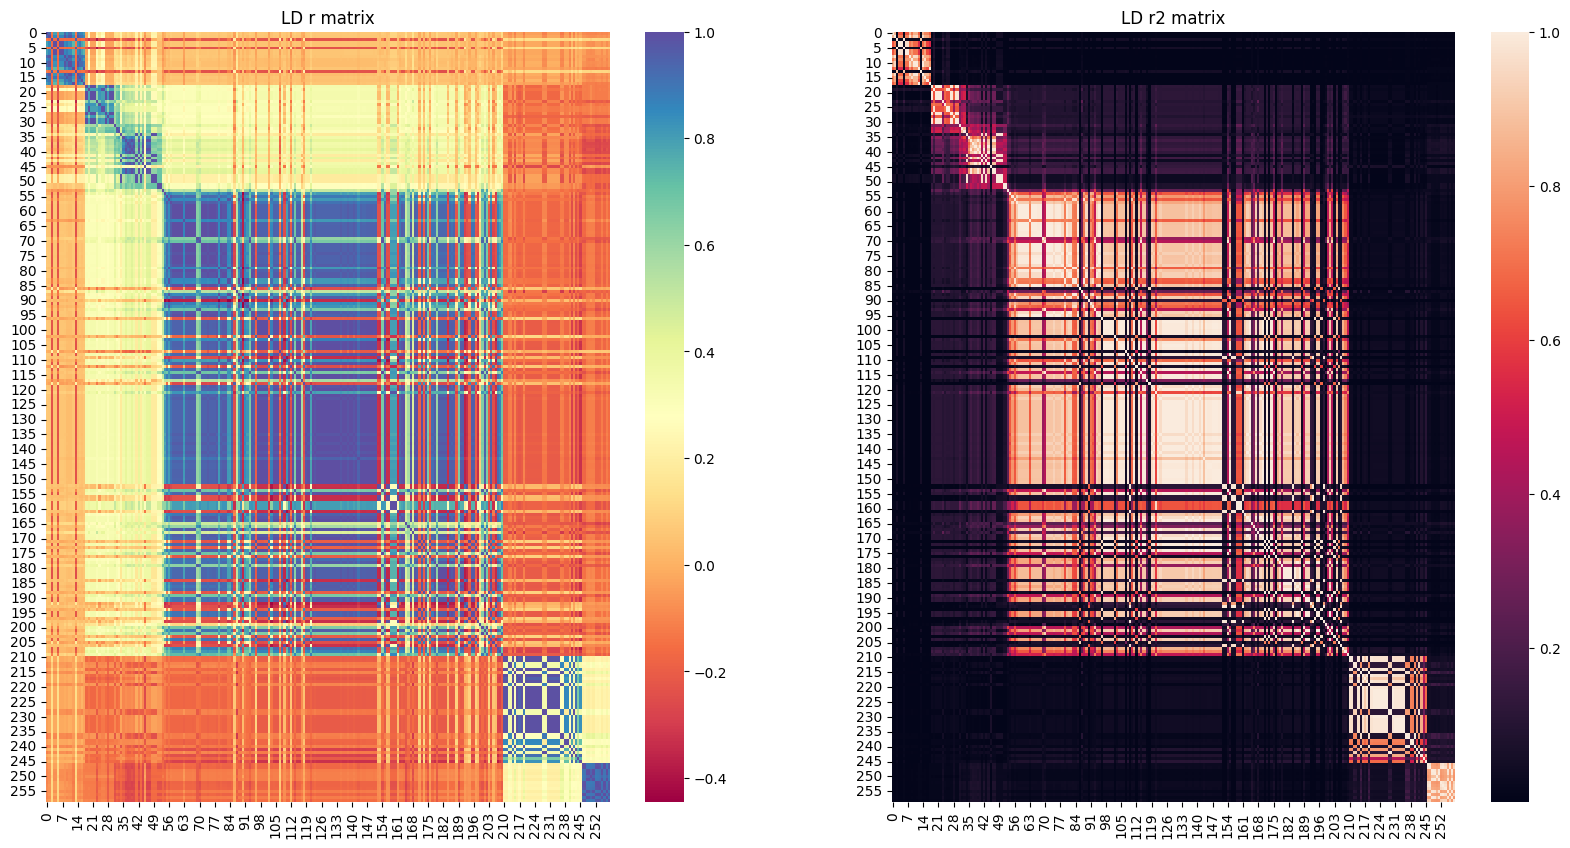

In [12]:
plt.figure(figsize=(10,10),dpi=200)
fig, ax = plt.subplots(ncols=2,figsize=(20,10))
sns.heatmap(data=R_df,cmap="Spectral",ax=ax[0])
sns.heatmap(data=R_df2,ax=ax[1])
ax[0].set_title("LD r matrix")
ax[1].set_title("LD r2 matrix")

In [8]:
print(type(R_df))  
print(R_df.shape) 
print(R_df[:5, :5]) 

<class 'numpy.ndarray'>
(119, 119)
[[ 1.        0.931797 -0.129286  0.796609  0.801998]
 [ 0.931797  1.       -0.156479  0.852617  0.858788]
 [-0.129286 -0.156479  1.       -0.156806 -0.162664]
 [ 0.796609  0.852617 -0.156806  1.        0.984765]
 [ 0.801998  0.858788 -0.162664  0.984765  1.      ]]


## Run finemapping with susieR

In [23]:
print(R_df.shape)
print(chr16_pos53828066["beta"].shape)
print(chr16_pos53828066["se"].shape)


(259, 259)
(259,)
(259,)


In [26]:
ro.r('set.seed(321)')
fit = susieR.susie_rss(
    bhat = chr16_pos53828066["beta"].values.reshape(len(R_df), 1),
    shat = chr16_pos53828066["se"].values.reshape(len(R_df), 1),
    R = R_df,
    L = 2,
    n = 359983
)

## Extract credible sets and pip

In [27]:
credible_sets = susieR.susie_get_cs(fit, coverage=0.95, min_abs_corr=0.5, Xcorr=R_df)
print(credible_sets)

$cs
$cs$L2
[1] 200

$cs$L1
[1] 75 79 82 83 90


$purity
   min.abs.corr mean.abs.corr median.abs.corr
L2     1.000000     1.0000000               1
L1     0.992977     0.9971908               1

$cs_index
[1] 2 1

$coverage
[1] 0.9714249 0.9705258

$requested_coverage
[1] 0.95




In [28]:

chr16_pos53828066.loc[:, "cs"] = 0
n_cs = len(susieR.susie_get_cs(fit, coverage = 0.95, min_abs_corr = 0.5, Xcorr = R_df)[0])
print(n_cs)
credible_sets = susieR.susie_get_cs(fit, coverage=0.95, min_abs_corr=0.5, Xcorr=R_df)[0]

for i in range(n_cs):
    cs_index = credible_sets[i]
    chr16_pos53828066.iloc[np.array(cs_index) - 1,  chr16_pos53828066.columns.get_loc("cs")] = i + 1


chr16_pos53828066["pip"] = np.array(susieR.susie_get_pip(fit))

2


In [29]:
chr16_pos53828066 = chr16_pos53828066.reset_index(drop=True)


In [30]:
cs_index = np.array(credible_sets[0])
for i in range(1, n_cs):
    cs_index = np.concatenate((cs_index, np.array(credible_sets[i])), axis=0)
credible_snps = chr16_pos53828066.loc[cs_index - 1, :]

print(credible_snps)

                  SNP minor_allele  minor_AF  low_confidence_variant  \
199  16:53839355:GT:G            G  0.405865                   False   
74    16:53800954:T:C            C  0.401795                   False   
78    16:53802494:C:T            T  0.402018                   False   
81    16:53803223:G:A            A  0.401998                   False   
82    16:53803574:T:A            A  0.402013                   False   
89    16:53806453:A:G            G  0.403039                   False   

     n_complete_samples        AC        ytx      beta        se     tstat  \
199              359983  292209.0  8021640.0  0.122079  0.012224   9.98638   
74               359983  289279.0  7983820.0  0.359304  0.011353  31.64900   
78               359983  289439.0  7988260.0  0.359699  0.011353  31.68240   
81               359983  289425.0  7987850.0  0.359563  0.011354  31.66990   
82               359983  289436.0  7988140.0  0.359554  0.011353  31.66960   
89               359983  29

In [31]:
credible_snps_sorted = credible_snps.sort_values(by="pip", ascending=False)
print(credible_snps_sorted[["SNP", "pip"]])

                  SNP       pip
199  16:53839355:GT:G  0.971425
78    16:53802494:C:T  0.311278
81    16:53803223:G:A  0.211721
82    16:53803574:T:A  0.210198
89    16:53806453:A:G  0.125799
74    16:53800954:T:C  0.111529


In [32]:
chr16_pos53828066.to_csv("../../data/locus_zoom/chr16_pos53828066_with_cs.csv", index=False)

In [33]:
import requests


chrom = credible_snps["CHR"]
pos = credible_snps["POS"]
pip = credible_snps["pip"]
crediable_snps_rs = []

def get_rsid(chrom, pos, genome="hg19"):
    url = f"https://api.genome.ucsc.edu/getData/track?genome={genome};track=dbSnp155;chrom=chr{chrom};start={pos-1};end={pos}"
    response = requests.get(url).json()
    if "dbSnp155" in response and response["dbSnp155"]:
        return response["dbSnp155"][0]["name"]
    return None

for c, p, pip in zip(chrom, pos, pip):
    rsid = get_rsid(c, p)
    crediable_snps_rs.append([rsid, c, p, pip])

df_crediable_snps= pd.DataFrame(crediable_snps_rs, columns=["rsID", "Chromosome", "Position", "pip"])
df_crediable_snps = df_crediable_snps.sort_values(by="pip", ascending=False)


In [34]:
df_crediable_snps[["rsID", "pip"]]

,rsID,pip
0,rs1425297614,0.971425
2,rs11642015,0.311278
3,rs62048402,0.211721
4,rs1558902,0.210198
5,rs56094641,0.125799
1,rs1421085,0.111529


## Create regional plot

/tmp/ipykernel_3054531/171383839.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_chr16_pos53828066[col_to_plot] = -np.log10(filtered_chr16_pos53828066["P"])


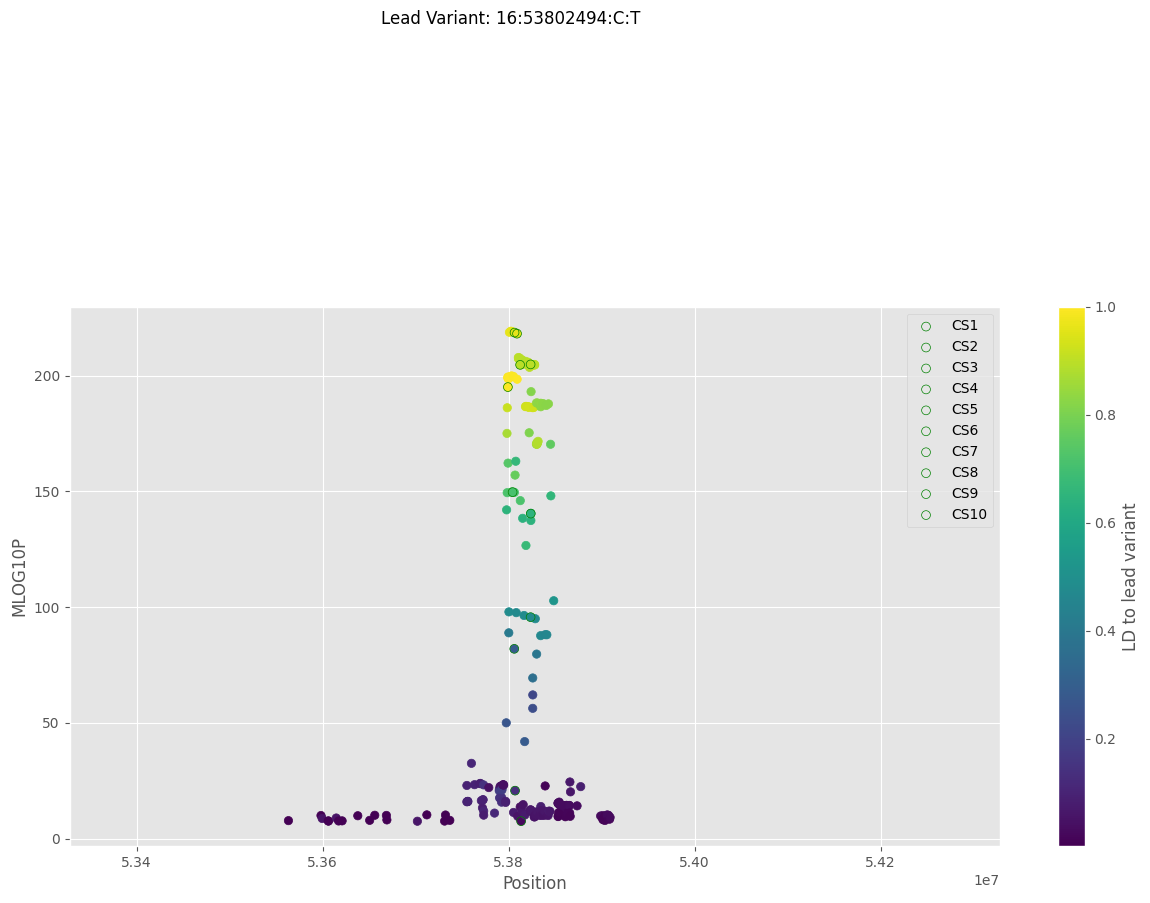

In [56]:
plt.style.use("ggplot")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

col_to_plot = "MLOG10P"
filtered_chr16_pos53828066[col_to_plot] = -np.log10(filtered_chr16_pos53828066["P"])

p = ax.scatter(
    filtered_chr16_pos53828066["POS"], 
    filtered_chr16_pos53828066[col_to_plot], 
    c=ld2[filtered_chr16_pos53828066["P"].idxmin()]
)

lead_x = filtered_chr16_pos53828066.loc[filtered_chr16_pos53828066["P"].idxmin(), "POS"]
lead_y = filtered_chr16_pos53828066.loc[filtered_chr16_pos53828066["P"].idxmin(), col_to_plot]

ax.annotate(
    f"Lead Variant: {filtered_chr16_pos53828066.loc[filtered_chr16_pos53828066['P'].idxmin(), 'SNPID']}", 
    (lead_x, lead_y), 
    textcoords="offset points", xytext=(0, lead_y + 2), ha='center', fontsize=12
)

credible_sets = susieR.susie_get_cs(fit, coverage=0.95, min_abs_corr=0.5, Xcorr=R_df)[0]

n_cs = len(credible_sets)
for i in range(n_cs):
    cs_index = credible_sets[i]
    pos = filtered_chr16_pos53828066.loc[np.array(cs_index) - 1, "POS"]
    y = filtered_chr16_pos53828066.loc[np.array(cs_index) - 1, col_to_plot]
    
    ax.scatter(pos, y, marker='o', s=40, label=f"CS{i+1}", edgecolors="green", facecolors="none")

plt.colorbar(p, label="LD to lead variant")
ax.set_xlabel("Position")
ax.set_ylabel(col_to_plot)
ax.set_xlim((53328066, 54328066))
plt.legend()
plt.show()


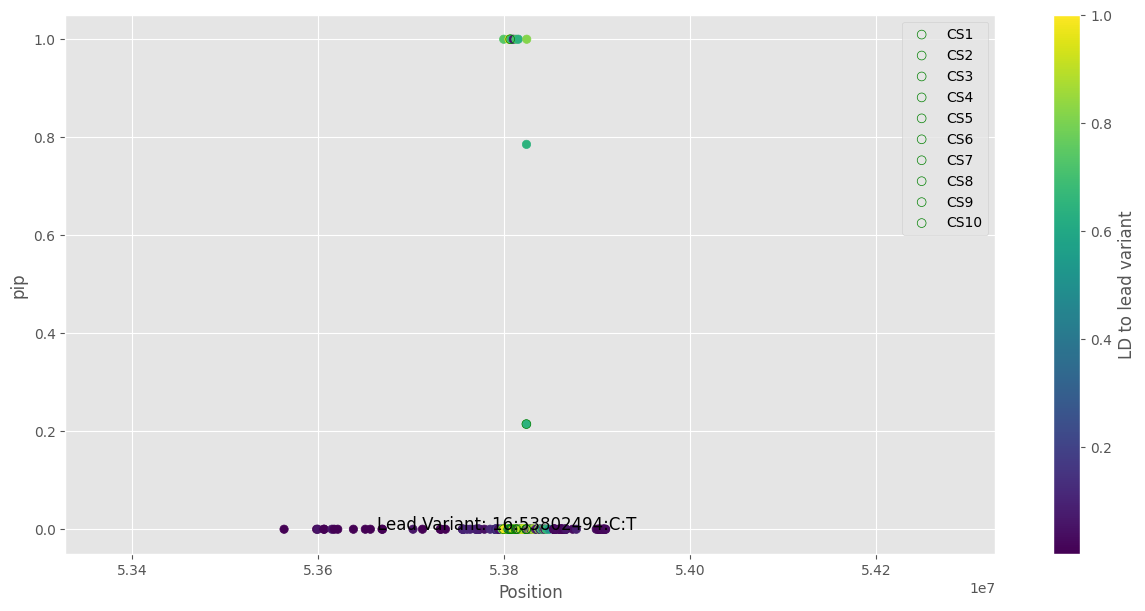

In [57]:
plt.style.use("ggplot")
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 7))

col_to_plot = "pip"
p = ax.scatter(
    filtered_chr16_pos53828066["POS"], 
    filtered_chr16_pos53828066[col_to_plot], 
    c=ld2[filtered_chr16_pos53828066["P"].idxmin()]
)

lead_x = filtered_chr16_pos53828066.loc[filtered_chr16_pos53828066["P"].idxmin(), "POS"]
lead_y = filtered_chr16_pos53828066.loc[filtered_chr16_pos53828066["P"].idxmin(), col_to_plot]

ax.annotate(
    f"Lead Variant: {filtered_chr16_pos53828066.loc[filtered_chr16_pos53828066['P'].idxmin(), 'SNPID']}", 
    (lead_x, lead_y), 
    textcoords="offset points", xytext=(0, lead_y + 0.02), ha='center', fontsize=12
)

credible_sets = susieR.susie_get_cs(fit, coverage=0.95, min_abs_corr=0.5, Xcorr=R_df)[0]
n_cs = len(credible_sets)

for i in range(n_cs):
    cs_index = credible_sets[i]
    pos = filtered_chr16_pos53828066.loc[np.array(cs_index) - 1, "POS"]
    y = filtered_chr16_pos53828066.loc[np.array(cs_index) - 1, col_to_plot]
    
    ax.scatter(pos, y, marker='o', s=40, label=f"CS{i+1}", edgecolors="green", facecolors="none")

plt.colorbar(p, label="LD to lead variant")
ax.set_xlabel("Position")
ax.set_ylabel(col_to_plot)
ax.set_xlim((53328066, 54328066))
# ax.set_ylim((0, 0.1))
plt.legend()
plt.show()
